# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

### Python3.6-OpenCV3.1 Based Curve Fitting

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import math
import pickle
import glob
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Function & Pipeline for solidWhite & solidYellow

I referenced below link to make it.

<p>https://campushippo.com/lessons/detect-highway-lane-lines-with-opencv-and-python-21438a3e2</p>
<p>https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0</p>
<p>https://medium.com/@ldesegur/a-lane-detection-approach-for-self-driving-vehicles-c5ae1679f7ee</p>

In [2]:
def roi(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8
    )
    img = np.copy(img)
    if lines is None:
        return

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)

    return img

def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """

    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, height),
        (width / 2, height / 2),
        (width, height),
    ]

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    cannyed_image = cv2.Canny(gray_image, 100, 200)
 
    cropped_image = roi(
        cannyed_image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )
 
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 180,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )
 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
 
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
        if math.fabs(slope) < 0.5:
            continue
        if slope <= 0:
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else:
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

    min_y = int(image.shape[0] * (3 / 5))
    max_y = int(image.shape[0])

    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))
 
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
 
    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
       deg=1
    ))
 
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))

    line_image = draw_lines(
        image,
        [[
            [left_x_start, max_y, left_x_end, min_y],
            [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness=5,
    )

    return line_image

## Build a Lane Finding Pipeline



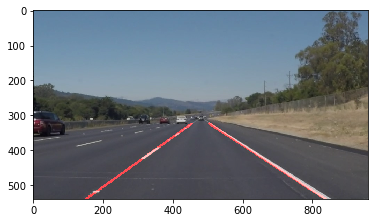

In [3]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
final_image = pipeline(image)
plt.imshow(final_image)

## Test on Videos

Let's try the one with the solid white lane on the right first ...

In [4]:
white_output = 'test_videos/solidWhiteRight_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos/solidWhiteRight_output.mp4
[MoviePy] Writing video test_videos/solidWhiteRight_output.mp4


100%|█████████▉| 221/222 [00:08<00:00, 26.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidWhiteRight_output.mp4 

CPU times: user 54 s, sys: 1.86 s, total: 55.9 s
Wall time: 8.82 s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [6]:
yellow_output = 'test_videos/solidYellowLeft_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos/solidYellowLeft_output.mp4
[MoviePy] Writing video test_videos/solidYellowLeft_output.mp4


100%|█████████▉| 681/682 [00:30<00:00, 22.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidYellowLeft_output.mp4 

CPU times: user 3min 10s, sys: 6.11 s, total: 3min 16s
Wall time: 30.6 s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

I applied two method to solve this problem.
1. Camera Calibration
2. Curve Fitting
Use Camera Calibration to get proper perspective info.
And Curve Fitting is based on Regression Analysis to get proper curve.

## Camera Calibration

In [8]:
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# make (54, 3) matrix that initialized zero
objp = np.zeros((ny * nx, 3), np.float32)
"""
result of np.mgrid[0:9, 0:6]

>>> np.mgrid[0:9, 0:6]
array([[[0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8]],

       [[0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5]]])

And below code doing mix first matrix column and second matrix colum

>>> np.mgrid[0:9, 0:6].T.reshape(-1,2)
array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [5, 0],
       [6, 0],
       [7, 0],
       [8, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [3, 1],
       [4, 1],
       [5, 1],
       [6, 1],
       [7, 1],
       [8, 1],
       [0, 2],
       [1, 2],
       [2, 2],
       [3, 2],
       [4, 2],
       [5, 2],
       [6, 2],
       [7, 2],
       [8, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [3, 3],
       [4, 3],
       [5, 3],
       [6, 3],
       [7, 3],
       [8, 3],
       [0, 4],
       [1, 4],
       [2, 4],
       [3, 4],
       [4, 4],
       [5, 4],
       [6, 4],
       [7, 4],
       [8, 4],
       [0, 5],
       [1, 5],
       [2, 5],
       [3, 5],
       [4, 5],
       [5, 5],
       [6, 5],
       [7, 5],
       [8, 5]])

objp[:,:2] makes it to 3D-coordinate.
It's just add zero to z-axis.
"""
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
# Find name which one has calibration
# at camera_cal directory that has jpg format.
images = glob.glob('camera_cal/calibration*.jpg')

# I can find the reference.
# http://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html
# And this output is comes from the reference.
# https://github.com/paramaggarwal/CarND-Advanced-Lane-Lines

#criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        #cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

## Distortion Correct for Pinhole Camera Model

I can find the reference.
1. http://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html
2. https://github.com/paramaggarwal/CarND-Advanced-Lane-Lines

In [9]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
# ret is the result of final re-projection error.
# mtx is 3 by 3 Camera Matrix
# dist is Distortion Coefficients
# rvecs is rotation vectors
# tvecs is translation vectors
# These all have relationship with homogeneous coordinates.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Get undistortion image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist3.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

# save above data at camera_cal/wide_dist_pickle.p
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

## Undistortion Image to use Perspective View

In [10]:
def undistort_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

## Get Strongest Red Channel

In [11]:
def abs_thresh(img, thresh=(0, 255)):
    # 1) Create a mask of 1's where image is > thresh_min and < thresh_max
    # make just zeros which one has same dimension of image
    binary = np.zeros_like(img)
    binary[(img >= thresh[0]) & (img <= thresh[1])] = 1

    # 2) Return this mask as your binary_output image
    return binary

## Sobel Filter

In [12]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):        
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    # It's Sobel Filter
    #
    # -1   0   +1
    # -2   0   +2       x filter - get horizontal change
    # -1   0   +1
    #
    # +1   +2   +1
    # 0    0    0       y filter - get vertical change
    # -1   -2   -1
    if  orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise 'orient not recognised'
    
    # 2) Take the absolute value of the derivative or gradient
    # change negative value to positive value
    abs_sobel = np.absolute(sobel)
    
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    
    # 4) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    
    # Get image between thresh[0] & thresh[1]
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 5) Return this mask as your binary_output image
    return grad_binary

## Perspective Transform to get proper region

In [13]:
def perspective_transform(image, debug=False, size_top=70, size_bottom=370):
    height, width = image.shape[0:2]
    output_size = height/2
    
    # Green Colored Area
    src = np.float32([[(width/2) - size_top, height*0.65], [(width/2) + size_top, height*0.65], [(width/2) + size_bottom, height-50], [(width/2) - size_bottom, height-50]])
    # Reject Area
    dst = np.float32([[(width/2) - output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) - output_size], [(width/2) + output_size, (height/2) + output_size], [(width/2) - output_size, (height/2) + output_size]])
    
    # Get the Perspective Transform Matrix src to dst
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Apply Perspective Transform to image with range(src, dst)
    warped = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR)
        
    return warped

## Edge Detection

In [14]:
def detect_edges(image, debug=False):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    # Extract Red Channel at perspective transformed image
    red_channel = image[:, :, 0]
    
    #plt.imshow(red_channel)
    #plt.savefig('extract_red_after_pt.jpg', format='jpg')
    
    # Apply Histogram Equalization
    # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    # http://docs.opencv.org/3.1.0/d4/d1b/tutorial_histogram_equalization.html
    equ = cv2.equalizeHist(red_channel)
    
    #plt.imshow(equ)
    #plt.savefig('histogram_equalization.jpg', format='jpg')
    
    # Get Strongest Red Element
    red_binary = abs_thresh(equ, thresh=(250, 255))
    
    #plt.imshow(red_binary)
    #plt.savefig('get_strongest_at_equ.jpg', format='jpg')
    
    # Apply Sobel X Filter
    gradx = abs_sobel_thresh(red_channel, orient='x', sobel_kernel=ksize, thresh=(30, 255))
    
    #plt.imshow(gradx)
    #plt.savefig('sobel_x_filter_with_red.jpg', format='jpg')
    
#     grady = abs_sobel_thresh(red_channel, orient='y', sobel_kernel=ksize, thresh=(30, 255))
#     mag_binary = mag_thresh(red_channel, sobel_kernel=ksize, mag_thresh=(30, 255))
#     dir_binary = dir_threshold(red_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(red_channel)
    combined[(red_binary == 1) | (gradx == 1)] = 1
        
    return combined

## Curve Fitting to Quadratic Function with Regression Analysis

In [15]:
# Curve Fitting Core
def fit_polynomials(binary_warped, debug=False):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    #print(binary_warped.shape[0]//2)
    #print(binary_warped[binary_warped.shape[0]//2:,:].tolist())
    #print(histogram.tolist())

    # Create an output image to draw on and  visualize the result
    # make the hist data to get all rgb 255
    # so it can get white color
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    #plt.imshow(out_img)
    #plt.savefig('get_white.jpg', format='jpg')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # midpoint is halves of x axis
    midpoint = np.int(histogram.shape[0]/2)
    
    # np.argmax() can get the max value of array index
    # leftx_base is start of left lane
    leftx_base = np.argmax(histogram[:midpoint])
    
    # rightx_base is start of right lane
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    # nonzero() can get nonzero value of array index
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    # Slice the image by nwindows(9) that is based on y-axis
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # sliced image y low
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        
        # sliced image y high
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # sliced image left lane x low(range)
        win_xleft_low = leftx_current - margin
        
        # sliced image left lane x high(range)
        win_xleft_high = leftx_current + margin
        
        # sliced image right lane x low(range)
        win_xright_low = rightx_current - margin
        
        # sliced image right lane x high(range)
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        
        #plt.imshow(out_img)
        #plt.savefig('make_left_lane_rect' + str(window) + '.jpg', format='jpg')
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        #plt.imshow(out_img)
        #plt.savefig('make_right_lane_rect' + str(window) + '.jpg', format='jpg')

        # Identify the nonzero pixels in x and y within the window
        # Get the nonzero value indices to make line
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            #print("len(good_left_inds) > minpix")
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        #else:
            #print("Bad left inds")
            
        if len(good_right_inds) > minpix:        
            #print("len(good_right_inds) > minpix")
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        #else:
            #print("Bad right inds")

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # It's same as Non-Linear Regression Analysis for second order(curve).
    # np.polyfit() can get the coefficient of the regression analysis.
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    # ploty start at 0 to end
    # np.linspace(a, b, c) can get the interval a to b sliced by c
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # get fitting x data of left lane
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    # get fitting x data of right lane
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    return ploty, left_fitx, right_fitx, left_fit, right_fit

## Calculate Curvature

In [16]:
def get_curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 20 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')

    return (left_curverad+right_curverad)/2

## Represent Perspective Rectangles

In [17]:
def get_perspective_rectangles(image):
    size_top=70
    size_bottom=370
    height, width = image.shape[0:2]
    output_size = height/2

    src = np.float32([[(width/2) - size_top, height*0.65], 
                      [(width/2) + size_top, height*0.65], 
                      [(width/2) + size_bottom, height-50], 
                      [(width/2) - size_bottom, height-50]])
    dst = np.float32([[(width/2) - output_size, (height/2) - output_size], 
                      [(width/2) + output_size, (height/2) - output_size], 
                      [(width/2) + output_size, (height/2) + output_size], 
                      [(width/2) - output_size, (height/2) + output_size]])

    return src, dst

def render_lane_area(image, ploty, left_fitx, right_fitx):
    # ready for rendering rectangle which one has proper perspective view.
    src, dst = get_perspective_rectangles(image)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    # left lane line
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    
    # right lane line
    # np.flipud() can flip array up/down direction.
    # This operation is proper for perspective view.
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    # get left & right lane info to pts
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    #plt.imshow(color_warp)
    #plt.savefig('need_perspective_rect.jpg', format='jpg')

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    #plt.imshow(newwarp)
    #plt.savefig('perspective_rect.jpg', format='jpg')

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

## Represent Perspective Left & Right Lane

In [18]:
def get_perspective_left_lane(image):
    size_top=70
    size_bottom=370
    left_lane_margin = 40
    height, width = image.shape[0:2]
    output_size = height/2

    src = np.float32([[(width/2) - size_top - left_lane_margin, height*0.65], 
                      [(width/2) - size_top, height*0.65], 
                      [(width/2) - size_bottom + left_lane_margin, height-50], 
                      [(width/2) - size_bottom - left_lane_margin, height-50]])
    dst = np.float32([[(width/2) - output_size - left_lane_margin, (height/2) - output_size], 
                      [(width/2) - output_size + left_lane_margin, (height/2) - output_size], 
                      [(width/2) - output_size + left_lane_margin, (height/2) + output_size], 
                      [(width/2) - output_size - left_lane_margin, (height/2) + output_size]])

    return src, dst

def get_perspective_right_lane(image):
    size_top=70
    size_bottom=370
    right_lane_margin = 100
    height, width = image.shape[0:2]
    output_size = height/2

    src = np.float32([[(width/2) + size_top - right_lane_margin, height*0.65], 
                      [(width/2) + size_top, height*0.65], 
                      [(width/2) + size_bottom + right_lane_margin, height-50], 
                      [(width/2) + size_bottom - right_lane_margin, height-50]])
    dst = np.float32([[(width/2) + output_size - right_lane_margin, (height/2) - output_size], 
                      [(width/2) + output_size + right_lane_margin, (height/2) - output_size], 
                      [(width/2) + output_size + right_lane_margin, (height/2) + output_size], 
                      [(width/2) + output_size - right_lane_margin, (height/2) + output_size]])

    return src, dst

def render_lane(image, ploty, left_fitx, right_fitx):
    src, dst = get_perspective_left_lane(image)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    # left lane line
    pts_left = np.array([np.transpose(np.vstack([left_fitx - 20, ploty]))])
    
    # right lane line
    # np.flipud() can flip array up/down direction.
    # This operation is proper for perspective view.
    #pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #pts_right = np.array([np.transpose(np.vstack([left_fitx + 20, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([left_fitx + 20, ploty])))])
    
    # get left & right lane info to pts
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0))
    
    #plt.imshow(color_warp)
    #plt.savefig('need_perspective_left_rect.jpg', format='jpg')

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    #plt.imshow(newwarp)
    #plt.savefig('perspective_left_rect.jpg', format='jpg')

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    src, dst = get_perspective_right_lane(image)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([right_fitx - 20, ploty]))])
    
    # right lane line
    # np.flipud() can flip array up/down direction.
    # This operation is proper for perspective view.
    #pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #pts_right = np.array([np.transpose(np.vstack([left_fitx + 20, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx + 20, ploty])))])
    
    # get left & right lane info to pts
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0))
    
    #plt.imshow(color_warp)
    #plt.savefig('need_perspective_right_rect.jpg', format='jpg')

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    #plt.imshow(newwarp)
    #plt.savefig('perspective_right_rect.jpg', format='jpg')

    # Combine the result with the original image
    result = cv2.addWeighted(result, 1, newwarp, 0.3, 0)
    
    return result

## Main

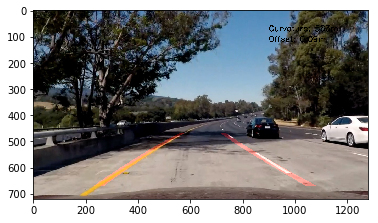

In [19]:
global_left_fit = None
global_right_fit = None

def process_image(input_image):
    global global_left_fit
    global global_right_fit
    
    #plt.imshow(input_image)
    #plt.savefig('origin.jpg', format='jpg')
    
    # step 1: undistort image
    image_undistort = undistort_image(input_image)
    
    #plt.imshow(image_undistort)
    #plt.savefig('after_undistort.jpg', format='jpg')
    
    # step 2: perspective transform
    image_transformed = perspective_transform(image_undistort)
    
    #plt.imshow(image_transformed)
    #plt.savefig('after_pt.jpg', format='jpg')
    
    # step 3: detect binary lane markings
    image_binary = detect_edges(image_transformed)
     
    #plt.imshow(image_binary)
    #plt.savefig('sobel_n_equ.jpg', format='jpg')
    
    # step 4: fit polynomials
    ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomials(image_binary)
    
    global_left_fit = left_fit
    global_right_fit = right_fit
    
    # step 5: draw lane area
    output_lane = render_lane_area(image_undistort, ploty, left_fitx, right_fitx)
    
    #plt.imshow(output_lane)
    #plt.savefig('rendering_green_lane_area.jpg', format='jpg')
    
    # step 6: draw left & right lane
    output_lane = render_lane(image_undistort, ploty, left_fitx, right_fitx)
    
    #plt.imshow(output_lane)
    #plt.savefig('rendering_left_right_lane.jpg', format='jpg')
    
    # step 7: print curvature
    curv = get_curvature(ploty, left_fitx, right_fitx)
    output_curvature = cv2.putText(output_lane, "Curvature: " + str(int(curv)) + "m", (900, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)

    # step 8: print road position
    xm_per_pix = 3.7/700
    left_lane_pos = left_fitx[len(left_fitx)-1]
    right_lane_pos = right_fitx[len(right_fitx)-1]
    road_pos = (((left_lane_pos + right_lane_pos) / 2) - 640) * xm_per_pix
    output_road_pos = cv2.putText(output_lane, "Offset: {0:.2f}m".format(road_pos), (900, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)

    # output from processing step
    output_image = output_road_pos
        
    # function should always output color images
    if len(output_image.shape) == 2:
        return cv2.cvtColor(np.float32(output_image), cv2.COLOR_GRAY2RGB)
    else:
        return output_image
    
test_image = mpimg.imread('test_images/challenge.jpg')
test_output = process_image(test_image)
plt.imshow(test_output)
#plt.savefig('final_output.jpg', format='jpg')

In [20]:
challenge_output = 'test_videos/challenge_curve_fit.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos/challenge_curve_fit.mp4
[MoviePy] Writing video test_videos/challenge_curve_fit.mp4


100%|██████████| 251/251 [00:36<00:00,  7.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/challenge_curve_fit.mp4 

CPU times: user 4min 4s, sys: 8.46 s, total: 4min 12s
Wall time: 37 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))